In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 26s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
training_data_df['토지면적over총연면적times공시지가'] = training_data_df['토지면적'] / training_data_df['총연면적'] * training_data_df['공시지가(만원)']

In [13]:
new_feature = ['토지면적over총연면적times공시지가']

In [14]:
cols_to_drop = [col for col in training_data_df.columns if ('x' in col)|('y' in col)]
cols_to_drop

['전용면적_max',
 'year_linear',
 'xnorm',
 'ynorm',
 'x_2nd',
 'y_2nd',
 'x_sin',
 'y_sin',
 'x_cos',
 'y_cos',
 'xy',
 'trade_type',
 '층max']

In [15]:
cols_to_drop = ['x_2nd', 'y_2nd', 'x_sin', 'y_sin', 'x_cos', 'y_cos', 'xy']

In [16]:
shap_summary_df = pd.read_csv(basedir + 'shap_top_40.csv', index_col=[0]).sort_values(['shap_summary_mean'], ascending=False)
print(shap_summary_df.shape)
shap_summary_df.head()

(40, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.728236,91.748818,93.689420,90.987252,90.040980,92.038941
토지면적over총연면적times공시지가,71.349711,78.388169,72.041624,76.794012,70.555412,73.825785
year_linear,65.081305,64.881935,65.103320,63.602370,64.795339,64.692854
건축년도,48.990676,50.261685,51.098290,53.588258,50.748241,50.937430
전용면적,37.790847,39.166366,38.171941,38.059139,39.396364,38.516931


In [17]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.728236,91.748818,93.689420,90.987252,90.040980,92.038941
토지면적over총연면적times공시지가,71.349711,78.388169,72.041624,76.794012,70.555412,73.825785
year_linear,65.081305,64.881935,65.103320,63.602370,64.795339,64.692854
건축년도,48.990676,50.261685,51.098290,53.588258,50.748241,50.937430
전용면적,37.790847,39.166366,38.171941,38.059139,39.396364,38.516931
ynorm,31.761683,33.149793,31.020283,31.490748,31.726159,31.829733
xy,23.927085,23.897834,22.516135,23.879272,21.181380,23.080341
x_2nd,20.885858,20.351355,20.279311,19.305666,19.843053,20.133049
층mean,13.341096,11.987581,11.088661,13.135700,11.995357,12.309679
주건축물수,11.403586,11.569739,11.230813,11.388285,11.472752,11.413035


In [18]:
top_40_df = shap_summary_df.iloc[:40,:]
print(top_40_df.shape)

(40, 6)


In [19]:
top_40_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.728236,91.748818,93.689420,90.987252,90.040980,92.038941
토지면적over총연면적times공시지가,71.349711,78.388169,72.041624,76.794012,70.555412,73.825785
year_linear,65.081305,64.881935,65.103320,63.602370,64.795339,64.692854
건축년도,48.990676,50.261685,51.098290,53.588258,50.748241,50.937430
전용면적,37.790847,39.166366,38.171941,38.059139,39.396364,38.516931


In [20]:
top_40_df.tail(20)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
호수대비주차수,4.763979,4.812563,4.456528,4.760808,4.724610,4.703698
용도지역명1,3.998052,3.995922,3.814652,3.544522,3.901760,3.850981
층norm,3.739721,2.910397,3.307946,3.580041,3.566564,3.420934
지구단위계획구역,2.869514,3.037930,2.987783,3.383858,3.048196,3.065456
도로접면,2.818437,2.843387,2.596018,3.387693,2.784605,2.886028
부속건축물수,2.562343,2.327817,3.184015,2.714311,2.895744,2.736846
지형높이,2.751996,2.908537,2.489990,2.570287,2.591295,2.662421
층min,2.160415,2.580975,2.383014,2.366238,2.449491,2.388027
가축사육제한구역,2.402346,2.445239,2.220096,2.340509,2.364254,2.354489
옥외자주식대수,2.459690,2.326517,2.292440,2.511130,2.167922,2.351540


In [21]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [22]:
cols_to_drop

['x_2nd', 'y_2nd', 'x_sin', 'y_sin', 'x_cos', 'y_cos', 'xy']

In [25]:
all_features = shap_summary_df.index.tolist()
print(len(all_features))
for col in cols_to_drop:
    if col in all_features:
        all_features.remove(col)
len(all_features)

40


34

In [26]:
selected_features = all_features

In [27]:
selected_features

['trade_type',
 '토지면적over총연면적times공시지가',
 'year_linear',
 '건축년도',
 '전용면적',
 'ynorm',
 '층mean',
 '주건축물수',
 '호수대비연면적',
 '토지이동상황',
 '총건축면적',
 '옥내자주식대수',
 'xnorm',
 '아파트지구',
 '호수대비부속건축물면적',
 '층',
 '총호수',
 '호수대비주차수',
 '용도지역명1',
 '층norm',
 '지구단위계획구역',
 '도로접면',
 '부속건축물수',
 '지형높이',
 '층min',
 '가축사육제한구역',
 '옥외자주식대수',
 '지붕_평지붕_fraction',
 '건물나이',
 '부속건축물면적',
 'month_sin',
 '(한강)폐기물매립시설_설치제한지역',
 '지형형상',
 '공원']

In [28]:
training_data_df = training_data_df[selected_features+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 39)


,trade_type,토지면적over총연면적times공시지가,year_linear,건축년도,전용면적,ynorm,층mean,주건축물수,호수대비연면적,토지이동상황,총건축면적,옥내자주식대수,xnorm,아파트지구,호수대비부속건축물면적,층,총호수,호수대비주차수,용도지역명1,층norm,지구단위계획구역,도로접면,부속건축물수,지형높이,층min,가축사육제한구역,옥외자주식대수,지붕_평지붕_fraction,건물나이,부속건축물면적,month_sin,(한강)폐기물매립시설_설치제한지역,지형형상,공원,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,758.319895,7.666667,1988,77.75,-9048.956121,9.0,1.0,98.537963,0,6.27131,0.0,5579.095707,0,0.0,2,54.0,0.0,0,0.222222,0,0,0.0,0,9.0,0,0.0,1.0,0,0.0,-0.866025,0,0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,758.319895,7.916667,1988,77.75,-9048.956121,9.0,1.0,98.537963,0,6.27131,0.0,5579.095707,0,0.0,2,54.0,0.0,0,0.222222,0,0,0.0,0,9.0,0,0.0,1.0,0,0.0,-0.500000,0,0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,758.319895,7.000000,1988,77.75,-9048.956121,9.0,1.0,98.537963,0,6.27131,0.0,5579.095707,0,0.0,4,54.0,0.0,0,0.444444,0,0,0.0,0,9.0,0,0.0,1.0,0,0.0,0.000000,0,0,0,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,758.319895,7.166667,1988,77.75,-9048.956121,9.0,1.0,98.537963,0,6.27131,0.0,5579.095707,0,0.0,9,54.0,0.0,0,1.000000,0,0,0.0,0,9.0,0,0.0,1.0,0,0.0,0.866025,0,0,0,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,758.319895,7.666667,1988,77.75,-9048.956121,9.0,1.0,98.537963,0,6.27131,0.0,5579.095707,0,0.0,1,54.0,0.0,0,0.111111,0,0,0.0,0,9.0,0,0.0,1.0,0,0.0,-0.866025,0,0,0,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [29]:
from sklearn.model_selection import KFold, GroupKFold

In [30]:
import lightgbm as lgb

In [31]:
from sklearn.metrics import r2_score

In [32]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

12

In [34]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 34)
y dist plot


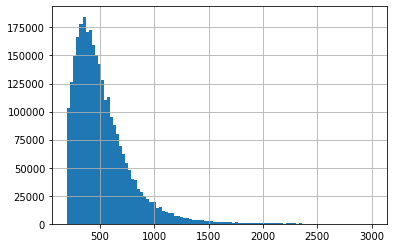

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4130
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 34


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 80.1486
[100]	valid_0's huber: 65.5353
[150]	valid_0's huber: 59.4788
[200]	valid_0's huber: 55.7242
[250]	valid_0's huber: 53.3491
[300]	valid_0's huber: 51.5132
[350]	valid_0's huber: 50.1176
[400]	valid_0's huber: 49.0057
[450]	valid_0's huber: 47.9242
[500]	valid_0's huber: 47.0103
[550]	valid_0's huber: 46.3628
[600]	valid_0's huber: 45.7251
[650]	valid_0's huber: 45.1444
[700]	valid_0's huber: 44.721
[750]	valid_0's huber: 44.1861
[800]	valid_0's huber: 43.7627
[850]	valid_0's huber: 43.3158
[900]	valid_0's huber: 42.9355
[950]	valid_0's huber: 42.588
[1000]	valid_0's huber: 42.2373
[1050]	valid_0's huber: 41.9393
[1100]	valid_0's huber: 41.688
[1150]	valid_0's huber: 41.4559
[1200]	valid_0's huber: 41.2091
[1250]	valid_0's huber: 40.9629
[1300]	valid_0's huber: 40.739
[1350]	valid_0's huber: 40.5468
[1400]	valid_0's huber: 40.3361
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


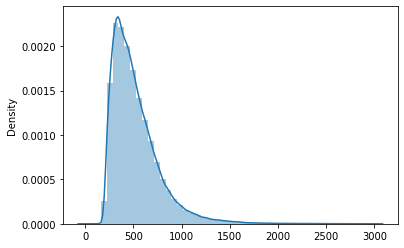

,model_0_shap_summary
0,94.373613
1,79.114167
2,64.319909
3,49.447281
4,39.564099
5,38.388769
6,12.461777
7,11.671881
8,8.910018
9,8.782499


Fold 0 end
Fold 1 start
(2926581, 34)
y dist plot


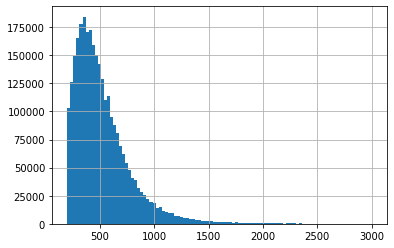

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4131
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 34


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 80.2845
[100]	valid_0's huber: 65.4452
[150]	valid_0's huber: 59.3297
[200]	valid_0's huber: 55.6109
[250]	valid_0's huber: 53.1054
[300]	valid_0's huber: 51.4239
[350]	valid_0's huber: 50.04
[400]	valid_0's huber: 48.8766
[450]	valid_0's huber: 47.9028
[500]	valid_0's huber: 47.1169
[550]	valid_0's huber: 46.4604
[600]	valid_0's huber: 45.6577
[650]	valid_0's huber: 44.9899
[700]	valid_0's huber: 44.4841
[750]	valid_0's huber: 43.9556
[800]	valid_0's huber: 43.4987
[850]	valid_0's huber: 43.1149
[900]	valid_0's huber: 42.716
[950]	valid_0's huber: 42.3522
[1000]	valid_0's huber: 42.0406
[1050]	valid_0's huber: 41.7446
[1100]	valid_0's huber: 41.4891
[1150]	valid_0's huber: 41.2587
[1200]	valid_0's huber: 41.0574
[1250]	valid_0's huber: 40.8425
[1300]	valid_0's huber: 40.6059
[1350]	valid_0's huber: 40.4214
[1400]	valid_0's huber: 40.2489
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


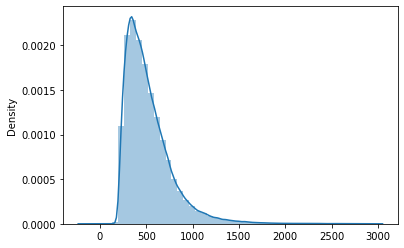

,model_0_shap_summary,model_1_shap_summary
0,94.373613,93.606349
1,79.114167,75.518589
2,64.319909,64.965059
3,49.447281,50.889625
4,39.564099,37.418517
5,38.388769,37.187583
6,12.461777,11.894514
7,11.671881,12.179422
8,8.910018,9.026741
9,8.782499,8.921934


Fold 1 end
Fold 2 start
(2926581, 34)
y dist plot


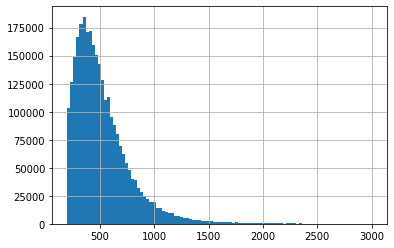

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4133
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 34


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.9553
[100]	valid_0's huber: 65.1584
[150]	valid_0's huber: 59.0492
[200]	valid_0's huber: 55.4656
[250]	valid_0's huber: 53.0516
[300]	valid_0's huber: 51.3969
[350]	valid_0's huber: 49.9538
[400]	valid_0's huber: 48.8516
[450]	valid_0's huber: 47.9457
[500]	valid_0's huber: 47.0947
[550]	valid_0's huber: 46.3969
[600]	valid_0's huber: 45.7688
[650]	valid_0's huber: 45.1756
[700]	valid_0's huber: 44.6021
[750]	valid_0's huber: 44.0482
[800]	valid_0's huber: 43.6221
[850]	valid_0's huber: 43.2814
[900]	valid_0's huber: 42.9035
[950]	valid_0's huber: 42.5104
[1000]	valid_0's huber: 42.1896
[1050]	valid_0's huber: 41.9034
[1100]	valid_0's huber: 41.6272
[1150]	valid_0's huber: 41.3693
[1200]	valid_0's huber: 41.1637
[1250]	valid_0's huber: 40.9471
[1300]	valid_0's huber: 40.7504
[1350]	valid_0's huber: 40.5418
[1400]	valid_0's huber: 40.3661
[1450]	

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\max6296\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-1a8a15d36573>", line 40, in <module>
    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
  File "c:\users\max6296\ml\lib\site-packages\lightgbm\engine.py", line 252, in train
    booster.update(fobj=fobj)
  File "c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py", line 2460, in update
    ctypes.byref(is_finished)))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\max6296\ml\lib\site-packages\IPython\core\interactiveshell.py", line 2045, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exce

TypeError: object of type 'NoneType' has no len()

<Figure size 432x288 with 0 Axes>

In [35]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_34_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
    
    display(shap_summary_df)        
    
    print('Fold {} end'.format(count))
    count += 1

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

In [ ]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [ ]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [ ]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [ ]:
shap_summary_df.index = x_train.columns

In [ ]:
shap_summary_df.to_csv(basedir + 'shap_top_34.csv')

In [ ]:
shap_summary_df = shap_summary_df.sort_values(['shap_summary_mean'], ascending=False)

In [ ]:
shap_summary_df.head(10)

In [ ]:
shap_summary_df.tail(10)